In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import docx
from textblob import TextBlob


plt.style.use('ggplot')


In [2]:
#so i am going to get all text and save to a csv, but first i am cleaning it up, 
doc = docx.Document('Files\\bitcoinData.docx')
# Initialize a list to store all paragraphs
data = []
for word in doc.paragraphs:
    if word.text.strip(): #this is getting rid of whitespace
        data.append([word.text])# here I am appending, adding the clean words/paragraphs to the list

#now i am creating the dataFrame to store it and get it ready to put in a csv
df = pd.DataFrame(data, columns=['text'])

#now i can save it to a csv
df.to_csv('Files\\data_text.csv', index=False)

#print so we know it worked, i will add try and except later
print("All document text has been saved to CSV.")

All document text has been saved to CSV.


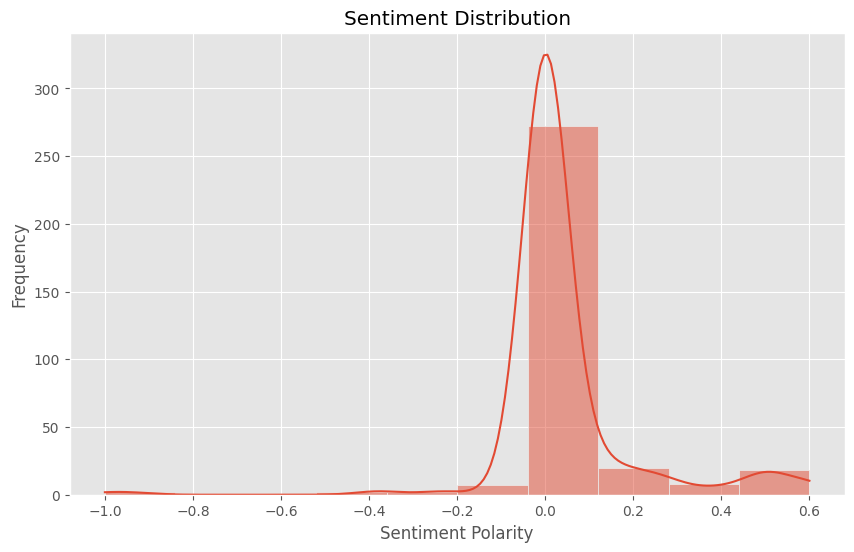

Average sentiment: 0.04


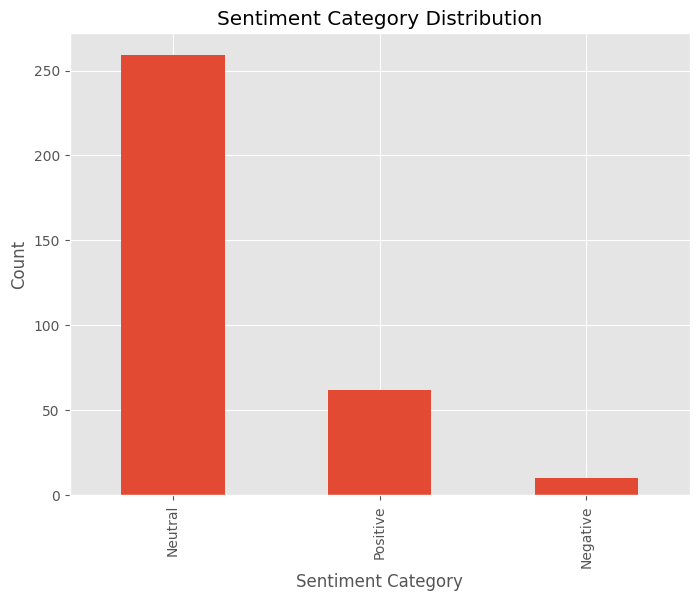

In [3]:
# Load the CSV file
df = pd.read_csv('Files\\data_text.csv')

# Ensure text is in the correct format
df['text'] = df['text'].astype(str)

# Perform sentiment analysis
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['text'].apply(get_sentiment)

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], kde=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

# Calculate and display average sentiment
average_sentiment = df['sentiment'].mean()
print(f"Average sentiment: {average_sentiment:.2f}")

# Categorize sentiments
def categorize_sentiment(polarity):
    if polarity > 0.05:
        return 'Positive'
    elif polarity < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_category'] = df['sentiment'].apply(categorize_sentiment)

# Display sentiment category distribution
sentiment_counts = df['sentiment_category'].value_counts()
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar')
plt.title('Sentiment Category Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()


Most common words:
[('the', 144), ('of', 91), ('in', 89), ('a', 79), ('to', 74), ('and', 53), ('for', 44), ('bitcoin', 40), ('s', 32), ('as', 32)]


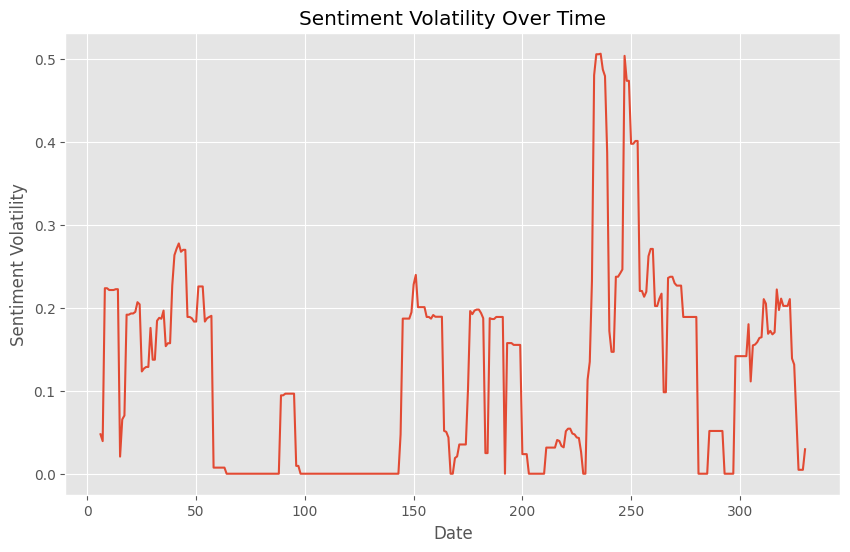

In [4]:
# Perform more in-depth analysis on the sentiment data

# 1. Time series analysis (if you have date information)
# Add a date column if it's available in your original data
# df['date'] = pd.to_datetime(df['date'])
# df = df.set_index('date')
# df['sentiment_ma'] = df['sentiment'].rolling(window=7).mean()

# 2. Word frequency analysis
from collections import Counter
import re

def get_word_freq(text):
    words = re.findall(r'\w+', text.lower())
    return Counter(words)

df['word_freq'] = df['text'].apply(get_word_freq)

# Get the most common words
all_words = Counter()
for freq in df['word_freq']:
    all_words.update(freq)

print("Most common words:")
print(all_words.most_common(10))

# 3. Correlation with Bitcoin price (if you have price data)
# Assuming you have a 'price' column
# df['price_change'] = df['price'].pct_change()
# correlation = df['sentiment'].corr(df['price_change'])
# print(f"Correlation between sentiment and price change: {correlation:.2f}")

# 4. Sentiment volatility
df['sentiment_volatility'] = df['sentiment'].rolling(window=7).std()

# Visualize sentiment volatility
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['sentiment_volatility'])
plt.title('Sentiment Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Volatility')
plt.show()


In [5]:
# Prepare data for machine learning

# 1. Create a function to get sentiment signal
def get_sentiment_signal(sentiment):
    if sentiment > 0.1:
        return 1  # Buy
    elif sentiment < -0.1:
        return -1  # Sell
    else:
        return 0  # Hold

df['sentiment_signal'] = df['sentiment'].apply(get_sentiment_signal)

# 2. Create lagged features
for i in range(1, 8):  # Create 7 days of lagged features
    df[f'sentiment_lag_{i}'] = df['sentiment'].shift(i)

# 3. Create a dataset for machine learning
features = ['sentiment', 'sentiment_volatility'] + [f'sentiment_lag_{i}' for i in range(1, 8)]
X = df[features].dropna()
y = df['sentiment_signal'].loc[X.index]

# 4. Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Scale the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Train a simple model (e.g., Logistic Regression)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# 7. Evaluate the model
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# 8. Save the model and scaler for later use
import joblib

joblib.dump(model, 'sentiment_model.joblib')
joblib.dump(scaler, 'sentiment_scaler.joblib')

print("Model and scaler saved for future use.")


              precision    recall  f1-score   support

          -1       1.00      1.00      1.00         1
           0       0.93      1.00      0.96        51
           1       1.00      0.69      0.82        13

    accuracy                           0.94        65
   macro avg       0.98      0.90      0.93        65
weighted avg       0.94      0.94      0.93        65

Model and scaler saved for future use.
